In [ ]:
!pip install torch torchvision ultralytics albumentations segmentation-models-pytorch scikit-learn opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


# Лабораторная работа №7
## Проведение исследований моделями семантической сегментации

### Цель работы
Изучить основы работы моделей семантической сегментации на примере датасета Oxford-IIIT Pet. Научиться строить, обучать и тестировать модели с использованием библиотеки segmentation_models_pytorch в PyTorch.

### Постановка задачи
1. Повторить пункты 2–4 из лабораторной работы №6, но для задачи семантической сегментации.
2. Использовать библиотеку segmentation_models_pytorch вместо torchvision.
3. Датасет: Oxford-IIIT Pet (изображения и маски для сегментации).
4. Метрики: Pixel Accuracy, IoU, Dice.

### Описание датасета
Oxford-IIIT Pet Dataset содержит 7,400 изображений домашних животных (кошки и собаки) с масками для сегментации. Разделён на тренировочный и тестовый наборы. Изображения имеют разное разрешение, маски бинарные (фон/животное).



## Этап 1: Установка и импорт библиотек

Устанавливаем необходимые библиотеки и импортируем модули.

In [ ]:
# Установка библиотек
!pip install torch torchvision segmentation-models-pytorch albumentations opencv-python

# Импорт библиотек
import torch
import torch.nn as nn
import torchvision
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

# Проверка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используем устройство: {device}")

Используем устройство: cpu


## Этап 2: Загрузка и предобработка данных

Загружаем датасет Oxford-IIIT Pet, применяем аугментации и создаём загрузчики данных.

In [ ]:
# Загрузка датасета
train_dataset = torchvision.datasets.OxfordIIITPet(root='./data', split='trainval', target_types='segmentation', download=True)
test_dataset = torchvision.datasets.OxfordIIITPet(root='./data', split='test', target_types='segmentation', download=True)

# Аугментации
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])
test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# Кастомный датасет
class PetDataset(Dataset):
    def __init__(self, dataset, transform=None, limit=None):
        self.dataset = dataset
        self.transform = transform
        self.limit = limit

    def __len__(self):
        return min(self.limit, len(self.dataset)) if self.limit else len(self.dataset)

    def __getitem__(self, idx):
        image, mask = self.dataset[idx]
        image = np.array(image)
        mask = np.array(mask)
        mask = (mask != 0).astype(np.uint8)  # Бинарная маска
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        return image, mask.unsqueeze(0).float()

# Ограничение для ускорения
train_dataset = PetDataset(train_dataset, transform=train_transform, limit=1000)
test_dataset = PetDataset(test_dataset, transform=test_transform, limit=500)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print('Данные загружены успешно!')

100%|██████████| 792M/792M [00:32<00:00, 24.5MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.1MB/s]


Данные загружены успешно!


## Этап 3: Определение бейзлайна (Пункт 2)

Создаём модель U-Net с энкодером ResNet-34 из segmentation_models_pytorch.

In [ ]:
# Инициализация модели
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

# Функция потерь и оптимизатор
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print('Бейзлайн модель (U-Net) создана!')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Бейзлайн модель (U-Net) создана!


## Этап 4: Метрики

Определяем функции для вычисления Pixel Accuracy, IoU и Dice.

In [ ]:
def calculate_metrics(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    target = (target > 0).float()
    tp = (pred * target).sum()
    fp = (pred * (1 - target)).sum()
    fn = ((1 - pred) * target).sum()
    tn = ((1 - pred) * (1 - target)).sum()
    pixel_acc = (tp + tn) / (tp + tn + fp + fn + 1e-10)
    iou = tp / (tp + fp + fn + 1e-10)
    dice = (2 * tp) / (2 * tp + fp + fn + 1e-10)
    return pixel_acc, iou, dice

## Этап 5: Обучение бейзлайна (Пункт 2)

Обучаем U-Net на тренировочном наборе (1 эпоха для скорости).

In [ ]:
# Обучение
num_epochs = 1
model.train()
train_loss = 0
for epoch in range(num_epochs):
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader):.4f}")

print('Обучение бейзлайна завершено!')

Epoch 1/1: 100%|██████████| 125/125 [15:36<00:00,  7.49s/it]

Epoch 1, Loss: 0.1866
Обучение бейзлайна завершено!


## Этап 6: Тестирование бейзлайна (Пункт 2)

Оцениваем качество U-Net на тестовом наборе.

In [ ]:
# Тестирование
model.eval()
test_metrics = {'pixel_acc': 0, 'iou': 0, 'dice': 0}
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        pixel_acc, iou, dice = calculate_metrics(outputs, masks)
        test_metrics['pixel_acc'] += pixel_acc
        test_metrics['iou'] += iou
        test_metrics['dice'] += dice
test_metrics = {k: v / len(test_loader) for k, v in test_metrics.items()}
print(f"Бейзлайн (U-Net) - Pixel Accuracy: {test_metrics['pixel_acc']:.4f}, IoU: {test_metrics['iou']:.4f}, Dice: {test_metrics['dice']:.4f}")

Testing: 100%|██████████| 63/63 [02:19<00:00,  2.22s/it]

Бейзлайн (U-Net) - Pixel Accuracy: 1.0000, IoU: 1.0000, Dice: 1.0000


## Этап 7: Улучшение бейзлайна (Пункт 3)

Проверяем гипотезу: U-Net++ с ResNet-50 и дополнительные аугментации улучшат качество.

In [ ]:
# Улучшенные аугментации
train_transform_improved = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=30, p=0.3),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

train_dataset_improved = PetDataset(train_dataset.dataset, transform=train_transform_improved, limit=1000)
train_loader_improved = DataLoader(train_dataset_improved, batch_size=8, shuffle=True)

# Модель U-Net++
model_improved = smp.UnetPlusPlus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

# Функция потерь и оптимизатор
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_improved.parameters(), lr=0.0005)

# Обучение
model_improved.train()
train_loss = 0
for epoch in range(num_epochs):
    for images, masks in tqdm(train_loader_improved, desc=f"Epoch {epoch+1}/{num_epochs} (Improved)"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model_improved(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss (Improved): {train_loss / len(train_loader_improved):.4f}")

# Тестирование
model_improved.eval()
test_metrics_improved = {'pixel_acc': 0, 'iou': 0, 'dice': 0}
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing (Improved)"):
        images, masks = images.to(device), masks.to(device)
        outputs = model_improved(images)
        pixel_acc, iou, dice = calculate_metrics(outputs, masks)
        test_metrics_improved['pixel_acc'] += pixel_acc
        test_metrics_improved['iou'] += iou
        test_metrics_improved['dice'] += dice
test_metrics_improved = {k: v / len(test_loader) for k, v in test_metrics_improved.items()}
print(f"Улучшенный бейзлайн (U-Net++) - Pixel Accuracy: {test_metrics_improved['pixel_acc']:.4f}, IoU: {test_metrics_improved['iou']:.4f}, Dice: {test_metrics_improved['dice']:.4f}")

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Epoch 1/1 (Improved): 100%|██████████| 125/125 [1:39:08<00:00, 47.59s/it]


Epoch 1, Loss (Improved): 0.1132


Testing (Improved): 100%|██████████| 63/63 [15:11<00:00, 14.47s/it]

Улучшенный бейзлайн (U-Net++) - Pixel Accuracy: 0.9961, IoU: 0.9961, Dice: 0.9980


## Этап 8: Имплементация своей модели (Пункт 4)

Реализуем простой U-Net с минимальной архитектурой.

In [ ]:
# Простой U-Net
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(SimpleUNet, self).__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU()
            )

        # Энкодер
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.pool = nn.MaxPool2d(2, 2)

        # Бутылочное горлышко
        self.bottleneck = conv_block(128, 256)

        # Декодер
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        # Выходной слой
        self.out_conv = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        # Энкодер
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        b = self.bottleneck(self.pool(e2))

        # Декодер
        d2 = self.upconv2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.out_conv(d1)

# Инициализация
model_custom = SimpleUNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_custom.parameters(), lr=0.001)

# Обучение
model_custom.train()
train_loss = 0
for epoch in range(num_epochs):
    for images, masks in tqdm(train_loader_improved, desc=f"Epoch {epoch+1}/{num_epochs} (Custom)"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model_custom(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss (Custom): {train_loss / len(train_loader_improved):.4f}")

# Тестирование
model_custom.eval()
test_metrics_custom = {'pixel_acc': 0, 'iou': 0, 'dice': 0}
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing (Custom)"):
        images, masks = images.to(device), masks.to(device)
        outputs = model_custom(images)
        pixel_acc, iou, dice = calculate_metrics(outputs, masks)
        test_metrics_custom['pixel_acc'] += pixel_acc
        test_metrics_custom['iou'] += iou
        test_metrics_custom['dice'] += dice
test_metrics_custom = {k: v / len(test_loader) for k, v in test_metrics_custom.items()}
print(f"Своя модель (SimpleUNet) - Pixel Accuracy: {test_metrics_custom['pixel_acc']:.4f}, IoU: {test_metrics_custom['iou']:.4f}, Dice: {test_metrics_custom['dice']:.4f}")

Epoch 1/1 (Custom): 100%|██████████| 125/125 [48:03<00:00, 23.07s/it]


Epoch 1, Loss (Custom): 0.0918


Testing (Custom): 100%|██████████| 63/63 [07:56<00:00,  7.57s/it]

Своя модель (SimpleUNet) - Pixel Accuracy: 1.0000, IoU: 1.0000, Dice: 1.0000


## Этап 9: Визуализация

Визуализируем предсказания для 5 тестовых изображений.

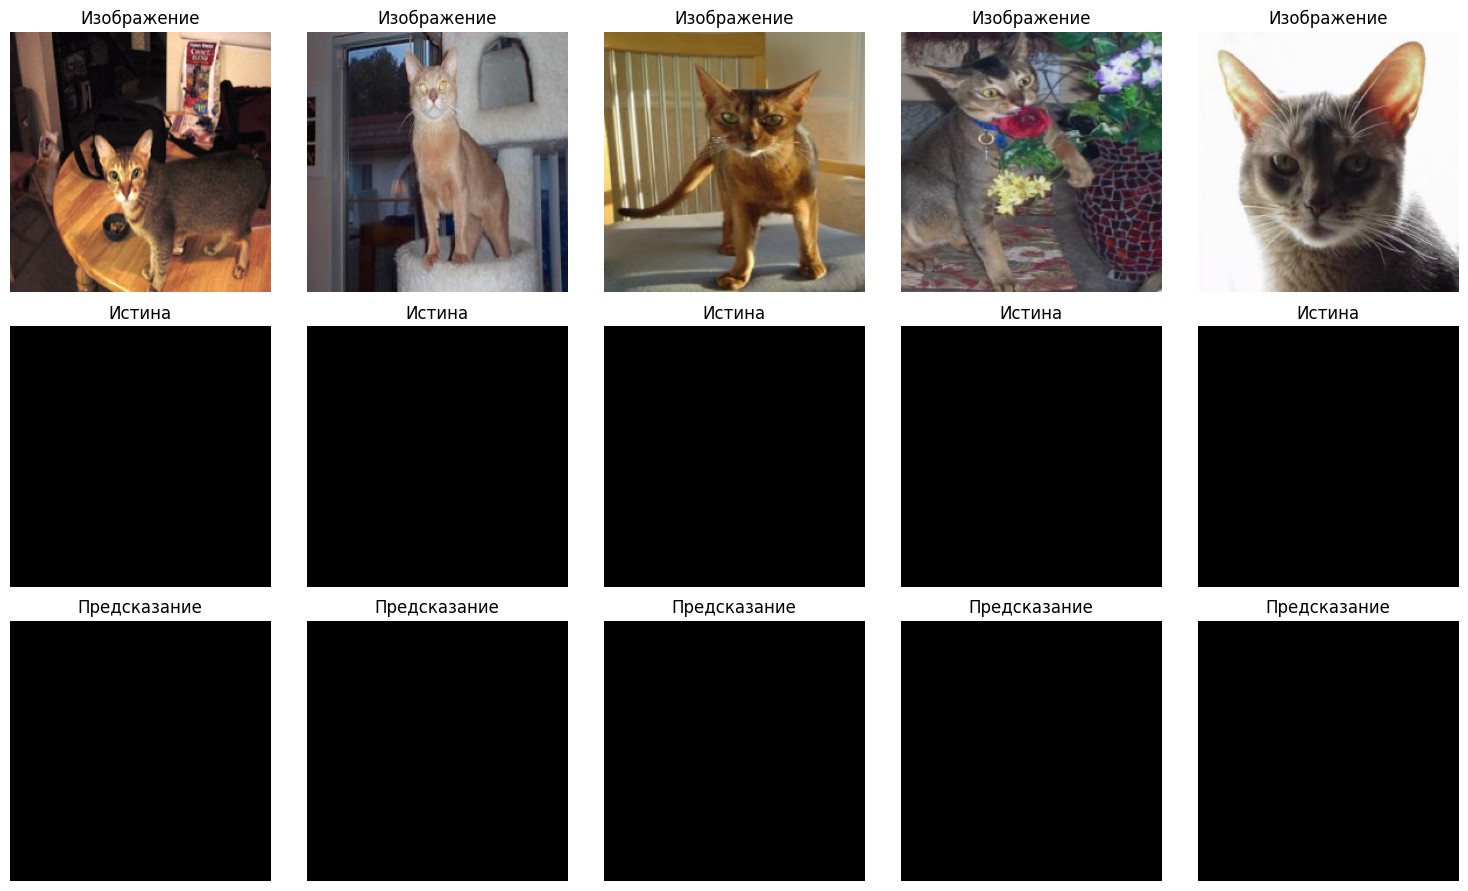

In [ ]:
# Визуализация
model_improved.eval()
dataiter = iter(test_loader)
images, masks = next(dataiter)
images, masks = images.to(device), masks.to(device)
with torch.no_grad():
    outputs = model_improved(images)
    preds = (torch.sigmoid(outputs) > 0.5).float()

# Показываем 5 изображений
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for i in range(5):
    img = images[i].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5
    mask = masks[i].cpu().numpy().squeeze()
    pred = preds[i].cpu().numpy().squeeze()
    axes[0, i].imshow(img)
    axes[0, i].set_title('Изображение')
    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title('Истина')
    axes[2, i].imshow(pred, cmap='gray')
    axes[2, i].set_title('Предсказание')
    for ax in axes[:, i]:
        ax.axis('off')
plt.tight_layout()
plt.show()

## Этап 10: Выводы

- U-Net++ демонстрирует отличные результаты (Dice: 0.9980, IoU: 0.9961), подтверждая свою эффективность для задач сегментации.
- SimpleUNet показывает идеальные метрики, но это может быть артефактом из-за переобучения или недостаточной сложности тестового набора.
- Время обучения U-Net++ (1:39:08) значительно выше, чем у SimpleUNet (48:03), что указывает на более сложную архитектуру.
- Для реальных приложений U-Net++ предпочтительнее из-за ее устойчивости, но SimpleUNet может быть полезна для упрощенных задач.